#DSCI 100 27 - Project Proposal

Aiden Chueh, Maxine Paredes, Ivan Wijaya, Ivy Yang

###Title:

Classification of Work Recruitment using Grades Percentage

###Introduction:

Most students looking to enter the workforce experience anxiety regarding the job search process, especially as information such as competitive admission averages and relevant extracurricular courses/degrees are scarce, not publicly accessible, or inaccurate. Our project aims to address this difficulty and provide a more reliable way to reach a concrete answer regarding job placement. Specifically, this project uses the Campus Recruitment dataset, which tracks candidates who have applied and attempts to determine whether an applicant will be placed or not based on their grade percentage

###Preliminary exploratory data analysis:

In [4]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



In [5]:
data <- read_csv("Placement_Data_Full_Class.csv")
data

Rows: 215 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): gender, ssc_b, hsc_b, hsc_s, degree_t, workex, specialisation, status
dbl (7): sl_no, ssc_p, hsc_p, degree_p, etest_p, mba_p, salary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
213,M,67,Others,67,Others,Commerce,73,Comm&Mgmt,Yes,59,Mkt&Fin,69.72,Placed,295000
214,F,74,Others,66,Others,Commerce,58,Comm&Mgmt,No,70,Mkt&HR,60.23,Placed,204000
215,M,62,Central,58,Others,Science,53,Comm&Mgmt,No,89,Mkt&HR,60.22,Not Placed,NA


In [6]:
tidy_data <- rename(data,
               candidate_id = sl_no,
               gender = gender,
               sec_grade_percent = ssc_p,
               sec_edu_board = ssc_b,
               h_sec_grade_percent = hsc_p,
               h_sec_education_board = hsc_b,
               h_sec_specialization = hsc_s,
               degree_percent = degree_p,
               degree_type = degree_t,
               work_experience = workex,
               e_test_percent = etest_p,
               mba_specialization = specialisation,
               mba_percent = mba_p,
               placement_status = status,
               salary = salary) |>
        select(sec_grade_percent, h_sec_grade_percent, degree_percent, e_test_percent, mba_percent, placement_status) |>
        mutate(placement_status = as.factor(placement_status)) 

tidy_data
     

sec_grade_percent,h_sec_grade_percent,degree_percent,e_test_percent,mba_percent,placement_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67.00,91.00,58.00,55.0,58.80,Placed
79.33,78.33,77.48,86.5,66.28,Placed
65.00,68.00,64.00,75.0,57.80,Placed
⋮,⋮,⋮,⋮,⋮,⋮
67,67,73,59,69.72,Placed
74,66,58,70,60.23,Placed
62,58,53,89,60.22,Not Placed


In [7]:
tidy_split <- initial_split(tidy_data, prop = 0.75, strata = placement_status)
training_data <- training(tidy_split)
training_data
testing_data <- testing(tidy_split)

sec_grade_percent,h_sec_grade_percent,degree_percent,e_test_percent,mba_percent,placement_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
55,49.8,67.25,55.00,51.58,Not Placed
46,49.2,79.00,74.28,53.29,Not Placed
58,70.0,61.00,54.00,52.21,Not Placed
⋮,⋮,⋮,⋮,⋮,⋮
80.6,82,77.6,91,74.49,Placed
67.0,67,73.0,59,69.72,Placed
74.0,66,58.0,70,60.23,Placed


In [8]:
class_count <- training_data |>
               group_by(placement_status) |>
               summarize(
                   count = n()
               )
class_count

placement_status,count
<fct>,<int>
Not Placed,50
Placed,111


In [9]:
average_predictors <- training_data |>
                      group_by(placement_status) |>
                      summarize(across(sec_grade_percent : mba_percent, mean))
# without using the function "na.rm = TRUE", we can see that every columns have no missing values
average_predictors

placement_status,sec_grade_percent,h_sec_grade_percent,degree_percent,e_test_percent,mba_percent
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Not Placed,57.70280,57.99920,61.72500,70.27140,61.6936
Placed,71.86378,70.31748,68.64324,73.67667,62.9264


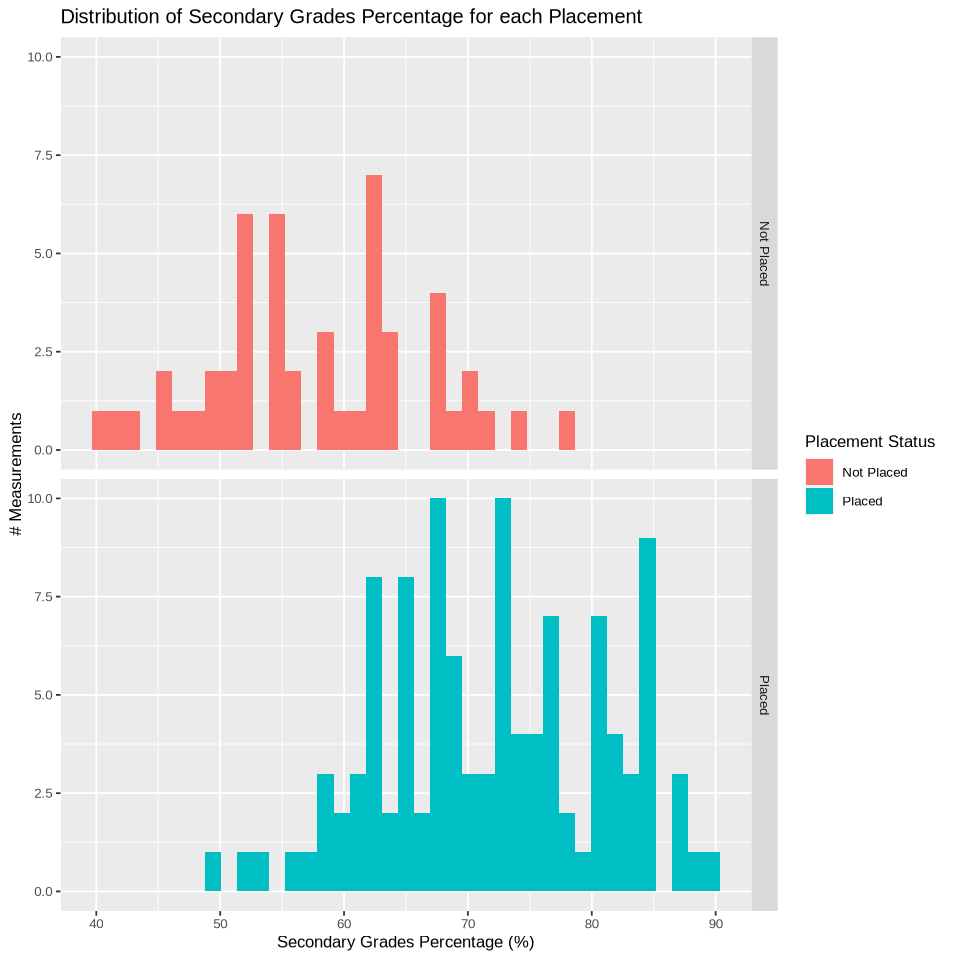

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8) 

sec_grade_plot <- training_data |>
                   ggplot(aes(x = sec_grade_percent, fill = placement_status)) +
                   geom_histogram(bins = 30, binwidth = 1.3) +
                   facet_grid(rows = vars(placement_status)) +
                   labs(x = "Secondary Grades Percentage (%)",
                   y = "# Measurements",
                   fill = "Placement Status") +
                   theme(text = element_text(size = 10)) +
                   ggtitle("Distribution of Secondary Grades Percentage for each Placement")
sec_grade_plot

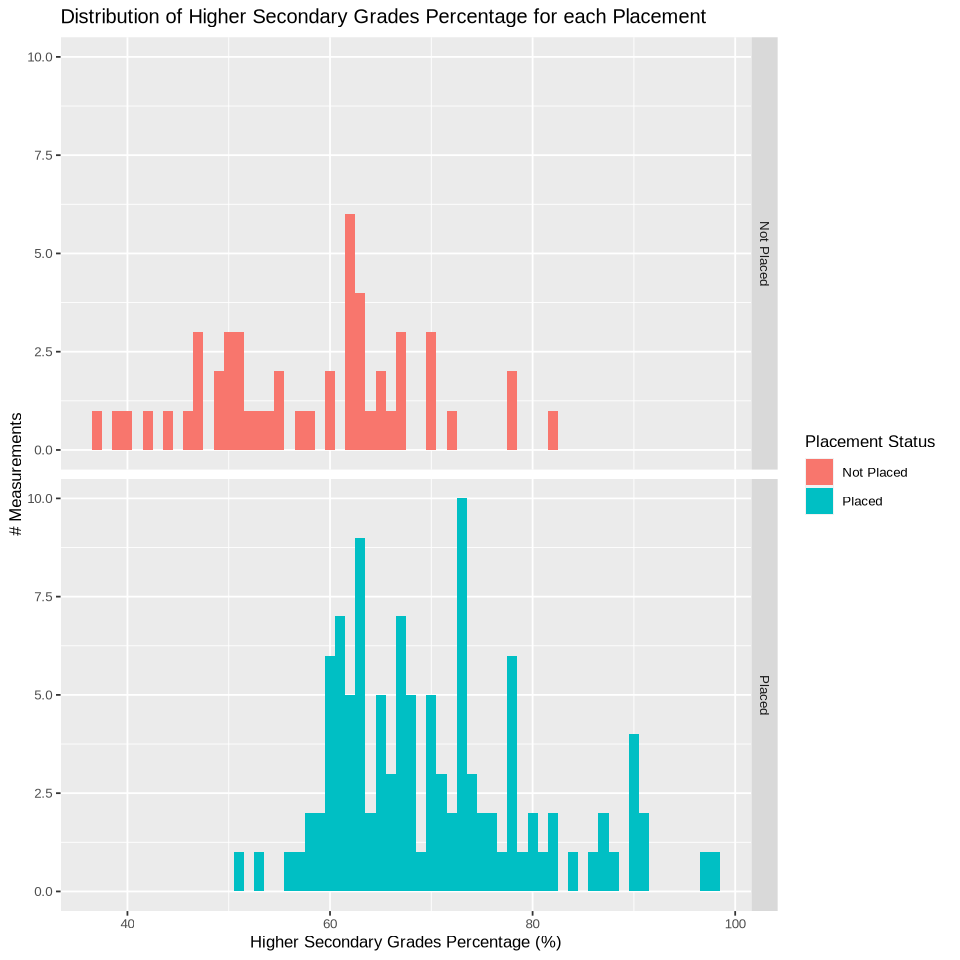

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8) 

h_sec_plot <- training_data |>
                   ggplot(aes(x = h_sec_grade_percent, fill = placement_status)) +
                   geom_histogram(bins = 30, binwidth = 1) +
                   facet_grid(rows = vars(placement_status)) +
                   labs(x = "Higher Secondary Grades Percentage (%)",
                   y = "# Measurements",
                   fill = "Placement Status") +
                   theme(text = element_text(size = 10)) +
                   ggtitle("Distribution of Higher Secondary Grades Percentage for each Placement")
h_sec_plot
     

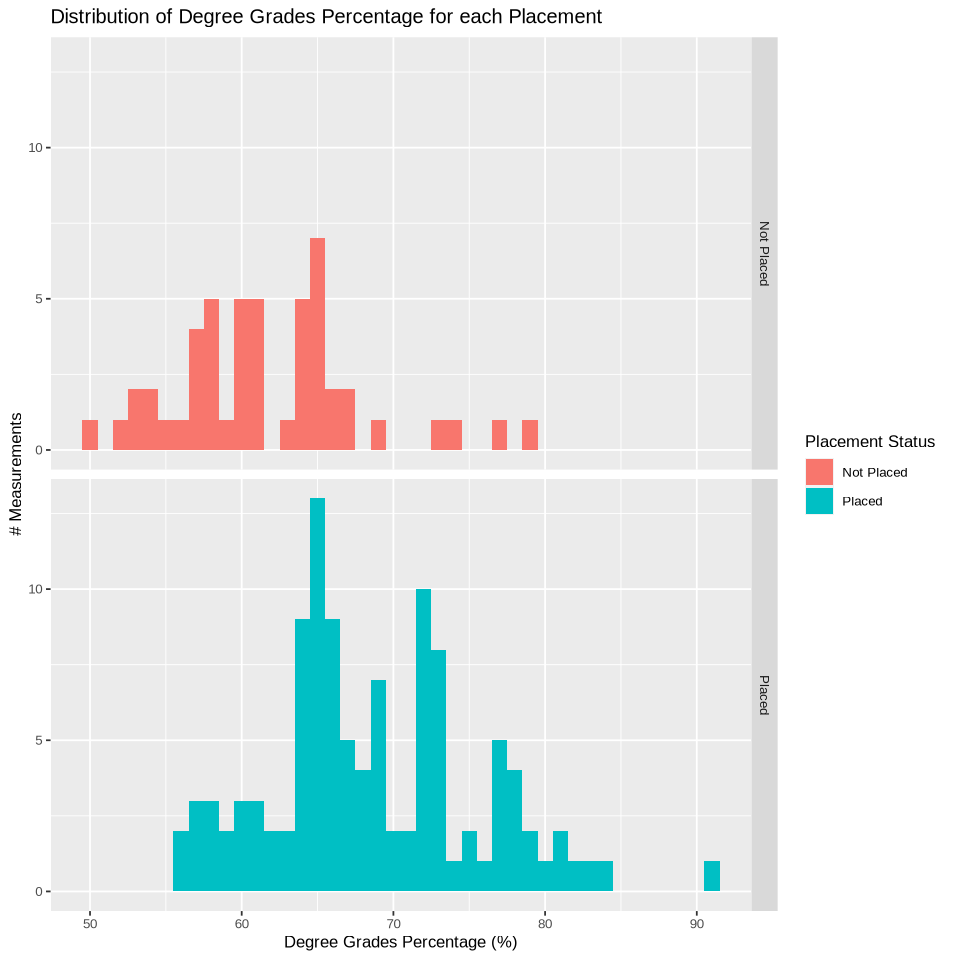

In [12]:
options(repr.plot.width = 8, repr.plot.height = 8) 

degree_plot <- training_data |>
                   ggplot(aes(x = degree_percent, fill = placement_status)) +
                   geom_histogram(bins = 30, binwidth = 1) +
                   facet_grid(rows = vars(placement_status)) +
                   labs(x = "Degree Grades Percentage (%)",
                   y = "# Measurements",
                   fill = "Placement Status") +
                   theme(text = element_text(size = 10)) +
                   ggtitle("Distribution of Degree Grades Percentage for each Placement")
degree_plot

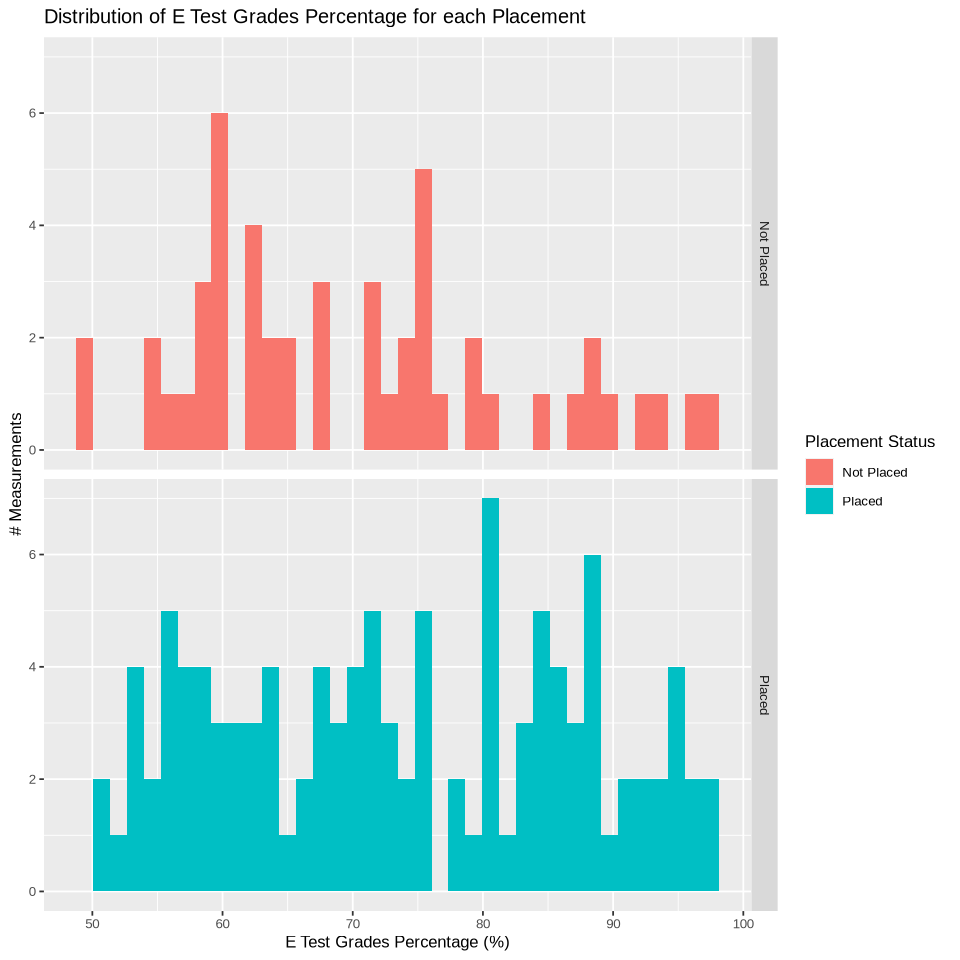

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8) 

e_test_plot <- training_data |>
                   ggplot(aes(x = e_test_percent, fill = placement_status)) +
                   geom_histogram(bins = 30, binwidth = 1.3) +
                   facet_grid(rows = vars(placement_status)) +
                   labs(x = "E Test Grades Percentage (%)",
                   y = "# Measurements",
                   fill = "Placement Status") +
                   theme(text = element_text(size = 10)) +
                   ggtitle("Distribution of E Test Grades Percentage for each Placement")
e_test_plot

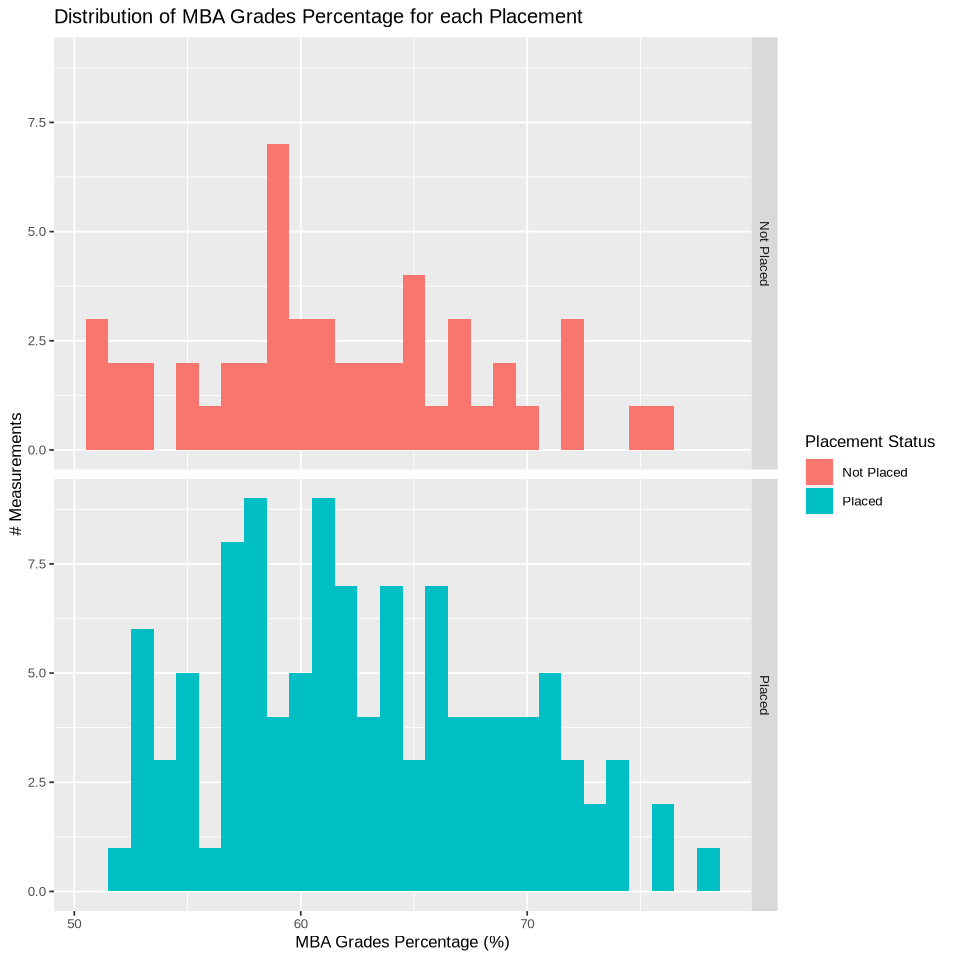

In [14]:
options(repr.plot.width = 8, repr.plot.height = 8) 

mba_plot <- training_data |>
                   ggplot(aes(x = mba_percent, fill = placement_status)) +
                   geom_histogram(bins = 30, binwidth = 1) +
                   facet_grid(rows = vars(placement_status)) +
                   labs(x = "MBA Grades Percentage (%)",
                   y = "# Measurements",
                   fill = "Placement Status") +
                   theme(text = element_text(size = 10)) +
                   ggtitle("Distribution of MBA Grades Percentage for each Placement")
mba_plot
     


###Methods:

For this project, we will only use a certain variable for part of the data analysis, specifically the 10th grade percentage (ssc_p), 12th grade (hsc_p), degree percentage (degree_p), test score percentage (etest_p), mba grade percentage (mba_p)  and placement status (status). We will not, however, filter the current data considering the row number is suitable for this data analysis which is 215. In the process of the project, we will also step up the total sample for “not placed” in the placement status, which will be using the “step_upsample” function from R.

We will use a scatterplot with the test score percentage at the x-axis versus mba grade percentage at the y-axis. Then, we will use the placement status as the color variable for the plot to get a better visualization. Adding layers of visualization with title and labeling will also be done to ensure an effective visualization.



###Expected outcomes and significance:

We expect to see that many different circumstances can result in successful work placement. Additionally, our findings can positively impact relevant demographics by providing a coherent way to provide relevant feedback for future applicants to tune their applications to be more competitive. Furthermore, institutions can use the data to improve the resources and opportunities for students to succeed, like changing curriculum in specific levels of education to better prepare students for example. This can help to answer other questions in the future such as “do employers have a preference for new graduate students that have previous work placement?” Alternatively, this can better inform exploration of work placement as an independent variable, like “how do the GPA requirements for different co-op placements vary among different industries?”
